In [1]:
from tkinter import filedialog
from tkinter import Tk
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from scipy.spatial import ConvexHull, Delaunay
import shap
import xgboost as xgb
import alphashape

root = Tk()
root.withdraw()

# read data
csv_file_path = filedialog.askopenfilename(title="Select Test-Data file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
Setting_File_path = filedialog.askopenfilename(title="Select Setting-file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))

# df define
df = pd.read_csv(csv_file_path)
df_setting = pd.read_excel(Setting_File_path)

feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()
target_variable = df_setting.loc[df_setting['Target_Variable'].notna(), 'Target_Variable'].values[0]

# mode check @ test-Data
mode_data = df["Mode"]
unique_modes = mode_data.drop_duplicates().tolist()
print("Unique Modes:", unique_modes)

# data define
target_mode = "2wfF4"
train_df = df[df['Mode'] != target_mode]
test_df = df[df['Mode'] == target_mode]

train_data = train_df[feature_vars]
test_data = test_df[feature_vars]
target_data = train_df[target_variable]

# 選んだ特徴量だけ分析対象にする
selected_features = ['TW','TRQCRKENG', 'NE']
print("selected_features:",selected_features)

#feature_vars

Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']
selected_features: ['TW', 'TRQCRKENG', 'NE']


In [5]:
from scipy.spatial import ConvexHull, Delaunay
import plotly.graph_objects as go
import numpy as np
import os

target_inclusion_rate = 1

# binary search
def find_optimal_layers(points, test_points, target_inclusion_rate):
    min_difference = float('inf')
    optimal_layers = 0
    
    lower_bound = 0
    upper_bound = 750

    while lower_bound <= upper_bound:
        num_layers = (lower_bound + upper_bound) // 2
        temp_points = points.copy()
        
        for _ in range(num_layers):
            hull = ConvexHull(temp_points)
            temp_points = np.delete(temp_points, hull.vertices, axis=0)
            
            if len(temp_points) == 0:
                break
        
        hull = ConvexHull(temp_points)
        deln = Delaunay(temp_points[hull.vertices])
        is_inside = deln.find_simplex(test_points) >= 0
        inclusion_rate = np.sum(is_inside) / len(test_points)
        
        difference = abs(target_inclusion_rate - inclusion_rate)
        
        if difference < min_difference:
            min_difference = difference
            optimal_layers = num_layers

        if inclusion_rate < target_inclusion_rate:
            upper_bound = num_layers - 1
        else:
            lower_bound = num_layers + 1
            
    return optimal_layers


# Prepare data
train_data_np = train_data[selected_features].to_numpy()
test_data_np = test_data[selected_features].to_numpy()
train_data_with_target = train_df[selected_features + [target_variable]]
points_with_target = train_data_with_target.to_numpy()

# Find the optimal layers to remove
optimal_layers = find_optimal_layers(train_data_np, test_data_np, target_inclusion_rate)

# Remove the optimal layers
for _ in range(optimal_layers):
    hull = ConvexHull(points_with_target[:, :-1])  # 目的変数を除外してConvexHull
    points_with_target = np.delete(points_with_target, hull.vertices, axis=0)

points = points_with_target[:, :-1]

# Compute final ConvexHull
final_hull = ConvexHull(points_with_target[:, :-1])
final_boundary_points = points_with_target[final_hull.vertices, :-1]

# Calculate outsider test points
deln = Delaunay(points_with_target[final_hull.vertices, :-1])
is_inside = deln.find_simplex(test_data_np) >= 0
outsider_test_points = test_data_np[~is_inside]
real_inclusion = np.sum(is_inside)/len(test_data_np)*100

# Excel export：目標包含率を満たすfinal_fullでのtrain_dataを出力
train_data_inside_hull = points_with_target[deln.find_simplex(points_with_target[:, :-1]) >= 0]
df_train_data_inside_hull = pd.DataFrame(train_data_inside_hull, columns=selected_features + [target_variable])
df_train_data_inside_hull.to_excel(f"TrainData_inside_hull(Inclusion_{real_inclusion:.1f}%)_target-{target_mode}.xlsx", index=False)


# test_data Export
excel_filename_test = f"TestData_{target_mode}.xlsx"

if not os.path.exists(excel_filename_test):
    test_df.to_excel(excel_filename_test, index=False)
else:
    print(f"{excel_filename_test} は既に存在するのでExcel-exportはスキップ")


if train_data_np.shape[1] == 3:
    # Plotting
    fig = go.Figure()

    # Plot original train data
    fig.add_trace(go.Scatter3d(x=train_data_np[:, 0],
                            y=train_data_np[:, 1],
                            z=train_data_np[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='green'),
                            name='Original Train Data'))

    # Plot original test data
    fig.add_trace(go.Scatter3d(x=test_data_np[:, 0],
                            y=test_data_np[:, 1],
                            z=test_data_np[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='red'),
                            name='Original Test Data'))

    # Plot boundary points after removing layers
    fig.add_trace(go.Scatter3d(x=final_boundary_points[:, 0],
                            y=final_boundary_points[:, 1],
                            z=final_boundary_points[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='blue'),
                            name=f'Boundary Points (remove {optimal_layers} layers)'))

    # Plot outsider test points
    fig.add_trace(go.Scatter3d(x=outsider_test_points[:, 0],
                            y=outsider_test_points[:, 1],
                            z=outsider_test_points[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='purple'),
                            name='Outsider Test Points'))

   # hull_mesh
    fig.add_trace(go.Mesh3d(x=points[:, 0],
                            y=points[:, 1],
                            z=points[:, 2],
                            i=final_hull.simplices[:, 0],
                            j=final_hull.simplices[:, 1],
                            k=final_hull.simplices[:, 2],
                            opacity=0.6,
                            color='orange'))

    # Axis labels
    fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                                yaxis_title=selected_features[1],
                                zaxis_title=selected_features[2]),
                    title=f'Convex Hull(Inclusion:{real_inclusion:.1f}%)_target-{target_mode}')

    # Save as HTML
    fig.write_html(f"Convex Hull(Inclusion_{real_inclusion:.1f}%)_target-{target_mode}.html")

else:
    print(f"{train_data_np.shape[1]}次元なので可視化しません")


TestData_2wfF4.xlsx は既に存在するのでExcel-exportはスキップ


In [20]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull, Delaunay
import itertools
import pyDOE2
from sklearn.neighbors import NearestNeighbors
import math

feature_ranges = {feature: (train_data[feature].min(), train_data[feature].max()) 
                    for feature in selected_features}

# 端部DOE
if len(selected_features) <= 6:
    # フルファクトリアル
    levels = [np.array([mn, mx]) for mn, mx in feature_ranges.values()]
    full_factorial_design = np.array(list(itertools.product(*levels)))
    experiment_design_df = pd.DataFrame(full_factorial_design, columns=selected_features)
else:
    # BBD
    num_factors = len(selected_features)
    bbd_design = pyDOE2.bbdesign(num_factors, center=1)
    scaled_design = np.zeros_like(bbd_design)
    for i, (feature, (min_val, max_val)) in enumerate(feature_ranges.items()):
        scaled_design[:, i] = bbd_design[:, i] * (max_val - min_val) / 2 + (max_val + min_val) / 2
    experiment_design_df = pd.DataFrame(scaled_design, columns=selected_features)

experiment_design_np = experiment_design_df.to_numpy()


def in_hull(point, hull):
    return hull.find_simplex(point) >=0

def lhs_outside_hull(num_samples, hull, feature_ranges):
    samples_outside_hull = []
    # num_samples分のサンプルが得られるまでループ
    while len(samples_outside_hull) < num_samples:
        # 一度にnum_samples分のサンプリングを行い、不足分を埋める
        lhs_samples = pyDOE2.lhs(len(feature_ranges), samples=num_samples, criterion='maximin')
        for sample in lhs_samples:
            if len(samples_outside_hull) >= num_samples:
                break  # 必要な数のサンプルが得られたらループを抜ける
            scaled_sample = np.array([fr[0] + (fr[1] - fr[0]) * s for fr, s in zip(feature_ranges.values(), sample)])
            if not in_hull(scaled_sample, hull):
                samples_outside_hull.append(scaled_sample)

    return samples_outside_hull


additional_samples = 200

# LHSサンプリング
hull = Delaunay(points[final_hull.vertices])
num_LHS_samples = math.ceil(additional_samples * 0.6)
LHS_samples = lhs_outside_hull(num_LHS_samples, hull, feature_ranges)
LHS_samples_np = np.array(LHS_samples)


#adaptive sampling
full_dataset_np = np.concatenate((train_data_np, experiment_design_np, LHS_samples_np))

nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree', n_jobs=-1).fit(full_dataset_np)
distances, _ = nbrs.kneighbors(full_dataset_np)

num_adaptive_samples = math.ceil(additional_samples * 0.4)

# データ密度が最も低い点からサンプリングする
low_density_points = np.argsort(-distances[:, 1])[:num_adaptive_samples]

adaptive_samples = np.zeros((num_adaptive_samples, full_dataset_np.shape[1]))
for i, point_index in enumerate(low_density_points):
    # サンプリングする点にノイズを加える
    sample = full_dataset_np[point_index] + np.random.normal(size=full_dataset_np.shape[1]) * distances[point_index, 1] * 0.5
    # 特徴量の範囲内にクリップする
    for j, feature in enumerate(selected_features):
        min_val, max_val = feature_ranges[feature]
        sample[j] = np.clip(sample[j], min_val, max_val)
    adaptive_samples[i] = sample


# Excel Export(Trainingは除く)
feature_names = selected_features
experiment_design_df['Category'] = 'edge DOE'

LHS_samples_df = pd.DataFrame(LHS_samples_np, columns=feature_names)
LHS_samples_df['Category'] = 'LHS'

adaptive_samples_df = pd.DataFrame(adaptive_samples, columns=feature_names)
adaptive_samples_df['Category'] = 'Adaptive'

all_samples_df = pd.concat([experiment_design_df, LHS_samples_df, adaptive_samples_df], ignore_index=True)
all_samples_df.to_excel(f'add_DOE_DataSet_(Inclusion_{real_inclusion:.1f}%).xlsx', index=False)


if train_data_np.shape[1] == 3:
    # Plot
    fig = go.Figure()

    # train data
    fig.add_trace(go.Scatter3d(x=train_data_np[:, 0],
                            y=train_data_np[:, 1],
                            z=train_data_np[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='green'),
                            name='Original Train Data'))

    # test data
    fig.add_trace(go.Scatter3d(x=test_data_np[:, 0],
                            y=test_data_np[:, 1],
                            z=test_data_np[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='red'),
                            name='Original Test Data'))

    # 境界点
    fig.add_trace(go.Scatter3d(x=final_boundary_points[:, 0],
                            y=final_boundary_points[:, 1],
                            z=final_boundary_points[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='orange'),
                            name=f'Boundary Points (remove {optimal_layers} layers)'))

    # 外装判定テストデータ
    fig.add_trace(go.Scatter3d(x=outsider_test_points[:, 0],
                            y=outsider_test_points[:, 1],
                            z=outsider_test_points[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='purple'),
                            name='Outsider Test Points'))

    # Convex hull
    fig.add_trace(go.Mesh3d(x=points[:, 0],
                            y=points[:, 1],
                            z=points[:, 2],
                            i=final_hull.simplices[:, 0],
                            j=final_hull.simplices[:, 1],
                            k=final_hull.simplices[:, 2],
                            opacity=0.4,
                            color='orange'))

    # End Point
    fig.add_trace(go.Scatter3d(x=experiment_design_np[:, 0],
                            y=experiment_design_np[:, 1],
                            z=experiment_design_np[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='black'),
                            name='EndPoint'))

    #LHS
    fig.add_trace(go.Scatter3d(
        x=LHS_samples_np[:, 0],
                                y=LHS_samples_np[:, 1],
                                z=LHS_samples_np[:, 2],
                                mode='markers',
                                marker=dict(size=4, color='blue'),
                                name='LHS Samples'))

    # Adaptive sampling
    fig.add_trace(go.Scatter3d(x=adaptive_samples[:, 0],
                            y=adaptive_samples[:, 1],
                            z=adaptive_samples[:, 2],
                            mode='markers',
                            marker=dict(size=4, color='yellow'),
                            name='Adaptive Samples'))


    # Set axis labels
    fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                                yaxis_title=selected_features[1],
                                zaxis_title=selected_features[2]),
                    title=f'Convex Hull+DOE(Inclusion:{real_inclusion:.1f}%)_target-{target_mode}')


    # HTML
    fig.write_html(f"Convex Hull+DOE(Inclusion_{real_inclusion:.1f}%)_target-{target_mode}.html")

else:
    print(f"{train_data_np.shape[1]}次元なので可視化しません")



以下、次元圧縮PCA＋Alpha_shapeによる外挿境界定義

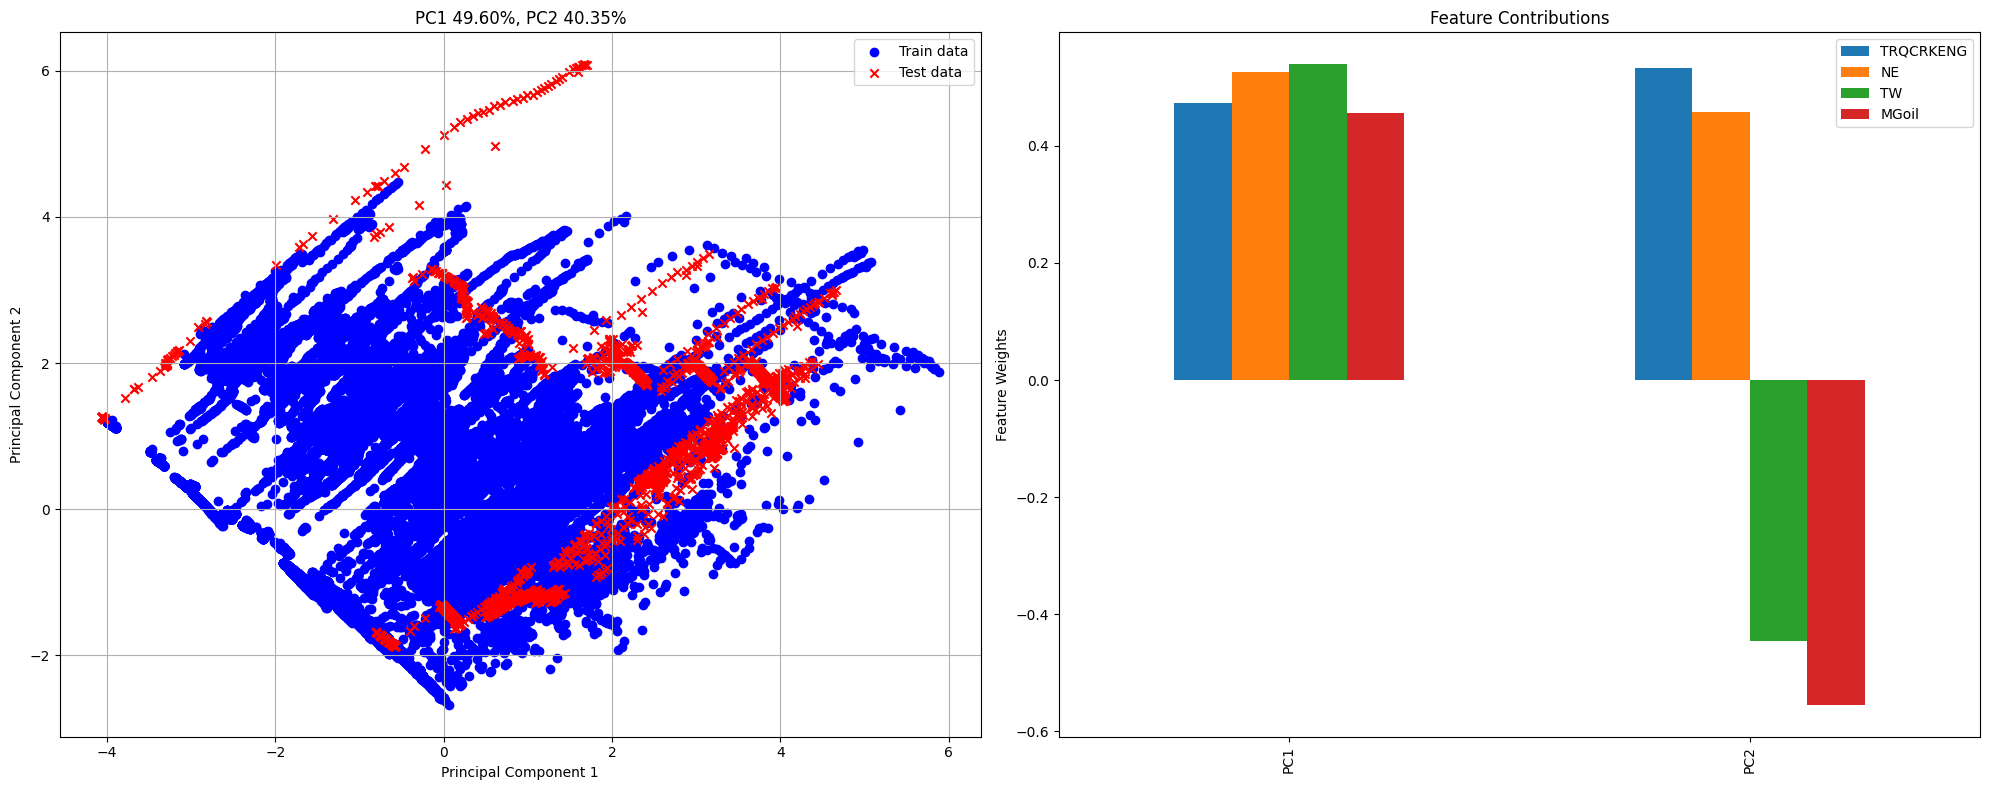

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

scaler = StandardScaler()
selected_train_data = scaler.fit_transform(train_data[selected_features])
selected_test_data = scaler.transform(test_data[selected_features])

# PCA
pca = PCA(n_components=0.9)
pca_train_data = pca.fit_transform(selected_train_data)
pca_test_data = pca.transform(selected_test_data)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Visualize PCA
ax = axes[0]
ax.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='Train data')
ax.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c='red', marker='x', label='Test data') 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# 分散寄与度計算
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio1 = explained_variance_ratio[0] * 100
explained_variance_ratio2 = explained_variance_ratio[1] * 100

ax.set_title(f'PC1 {explained_variance_ratio1:.2f}%, PC2 {explained_variance_ratio2:.2f}%')
ax.legend(loc='upper right')
ax.grid(True)

# feature contribution
components_df = pd.DataFrame(pca.components_, columns=selected_features, index=[f'PC{i+1}' for i in range(len(pca.components_))])

# Visualize
ax = axes[1]
components_df.iloc[:2, :].plot(kind='bar', ax=ax)
ax.set_title('Feature Contributions')
ax.set_ylabel('Feature Weights')

plt.tight_layout()
plt.show()


For alpha=0, number of outsider_test_indices: 105
For alpha=0, number of boundary_train_indices: 129


TypeError: float() argument must be a string or a number, not 'Point'

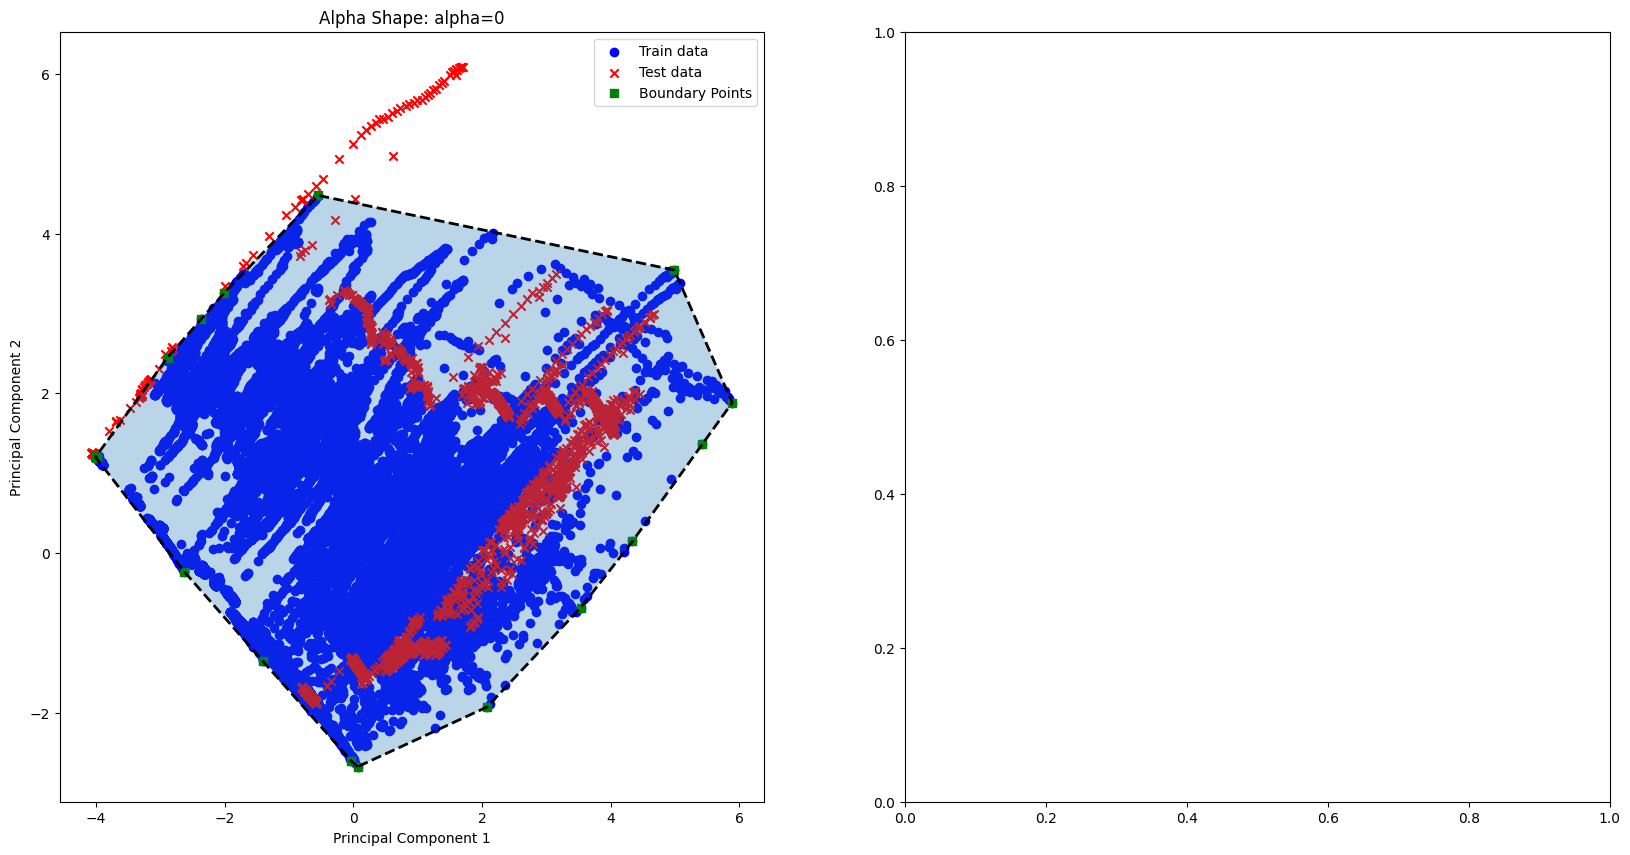

In [21]:
from shapely.geometry import MultiPoint, Point
from alphashape import alphashape
import matplotlib.pyplot as plt
import numpy as np

# alpha_shape外形に対しpointとの距離がthresholdよりも小さければTrueを返す
def is_near_boundary(point, alpha_shape, threshold=1e-5):
    point = Point(point)
    return alpha_shape.boundary.distance(point) < threshold

# Initialize
outsider_test_points = {}
boundary_train_points = {}
original_boundary_train_points = {}
original_outsider_test_points = {}

# 任意のalpha値を設定
arbitrary_alpha_value = 1

fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # 1行2列のプロットに修正

alpha_values = [0, arbitrary_alpha_value]  # alpha=0と任意の値を使用
for i, alpha_value in enumerate(alpha_values):
    ax = axes[i]
    alpha_shape = alphashape(pca_train_data, alpha=alpha_value)
    
    # outside : alpha shape
    outsider_test_indices = [not alpha_shape.contains(Point(point)) for point in pca_test_data]
    
    outsider_test_points[alpha_value] = pca_test_data[np.where(outsider_test_indices)]
    
    # boundary : alpha shape
    boundary_train_indices = [is_near_boundary(point, alpha_shape) for point in pca_train_data]
    boundary_train_points[alpha_value] = pca_train_data[np.where(boundary_train_indices)]
    
    print(f"For alpha={alpha_value}, number of outsider_test_indices: {np.sum(outsider_test_indices)}")
    print(f"For alpha={alpha_value}, number of boundary_train_indices: {np.sum(boundary_train_indices)}")

    # 元の特徴空間でのデータ
    original_boundary_train_indices = np.where(boundary_train_indices)[0]
    original_boundary_train_points[alpha_value] = scaler.inverse_transform(selected_train_data[original_boundary_train_indices])

    # 元の特徴空間でのデータ
    original_outsider_test_points[alpha_value] = test_data[selected_features].iloc[np.where(outsider_test_indices)[0]]

    # Plotting
    ax.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='Train data')
    ax.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c='red', marker='x', label='Test data')
    ax.scatter(boundary_train_points[alpha_value][:, 0], boundary_train_points[alpha_value][:, 1], c='green', marker='s', label='Boundary Points')

    if alpha_shape.geom_type == 'Polygon':
        ax.plot(*alpha_shape.exterior.xy, c='k', linestyle='--', lw=2)
        ax.fill(*alpha_shape.exterior.xy, alpha=0.3)
    elif alpha_shape.geom_type == 'MultiPolygon':
        for shape in alpha_shape:
            ax.plot(*shape.exterior.xy, c='k', linestyle='--', lw=2)
            ax.fill(*shape.exterior.xy, alpha=0.3)

    ax.set_title(f'Alpha Shape: alpha={alpha_value}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
## PCA空間で外挿境界定義⇒高次元にMapping⇒convex_hull

import plotly.graph_objects as go
from scipy.spatial import ConvexHull

fig = go.Figure()
alpha_value = 3

# Add scatter plot for original train data points
fig.add_trace(go.Scatter3d(x=train_data[selected_features].iloc[:, 0],
                           y=train_data[selected_features].iloc[:, 1],
                           z=train_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='green'),
                           name='Train Data'))

# Add scatter plot for original test data points
fig.add_trace(go.Scatter3d(x=test_data[selected_features].iloc[:, 0],
                           y=test_data[selected_features].iloc[:, 1],
                           z=test_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='red'),
                           name='Test Data'))

# Add scatter plot for original_boundary_train_points
fig.add_trace(go.Scatter3d(x=original_boundary_train_points[alpha_value][:, 0],
                           y=original_boundary_train_points[alpha_value][:, 1],
                           z=original_boundary_train_points[alpha_value][:, 2],
                           mode='markers',
                           marker=dict(size=4, color='blue'),
                           name='Boundary Points'))

# Calculate Convex Hull for original_boundary_train_points
boundary_points = original_boundary_train_points[alpha_value]
hull = ConvexHull(boundary_points)

# Add mesh for Convex Hull
fig.add_trace(go.Mesh3d(x=boundary_points[:, 0],
                         y=boundary_points[:, 1],
                         z=boundary_points[:, 2],
                         i=hull.simplices[:, 0],
                         j=hull.simplices[:, 1],
                         k=hull.simplices[:, 2],
                         opacity=0.4,
                         color='orange',
                         name='Convex Hull'))

# Add scatter plot for original_outsider_test_points
fig.add_trace(go.Scatter3d(x=original_outsider_test_points[alpha_value].iloc[:, 0],
                           y=original_outsider_test_points[alpha_value].iloc[:, 1],
                           z=original_outsider_test_points[alpha_value].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='purple'),
                           name='Outsider Test Points'))

# Set axis label
fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                             yaxis_title=selected_features[1],
                             zaxis_title=selected_features[2]),
                  title=f'3D_PCA-mapping_alpha={alpha_value}')

# Save & Show
fig.write_html(f"3D_PCA-mapping_alpha={alpha_value}.html")
#fig.show()